# Interferogram processing for calibration

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift
from skimage.restoration import unwrap_phase
from skimage.io import imread_collection
from skimage.draw import disk
%matplotlib ipympl

In [4]:
images = imread_collection('data/measurements/*.png')
N = len(images)
ref = images[0].astype(float)


In [ ]:
def extract_phase(img, pad_factor = 2, cx = 0, cy = 0, r = 50, AUTOPEAK = True,  SETUP = False):
    '''------------------------------------------------------------------------------------
    Extract the phase for retarded interferograms relatively to a reference.
    Inputs:
       img (ndarray): the image to extract the phase from.
       pad_factor (int) factor by which to pad the image.
       cx (int): x-coordinate of the center of the frequency peakc of interest.
       cy (int): y-coordinate of the center of the frequency peakc of interest.
       r (int): radius of the disk to extract the phase from.
       AUTOPEAK (bool): if True the center of the frequency peak is automatically detected.
       SETUP (bool): if True the function will display the raw, raw + roi, and processed interferograms.    
    Returns:
        phase (ndarray): the phase extracted from the image
    To do:
    TODO: input checks
    TODO: add option to use a hanning window
    TODO: make autopeak use the compleate half of the image and adapt full coordinate conversion
    ------------------------------------------------------------------------------------'''
    H, W = img.shape
    
    pad_shape = (int(H * pad_factor), int(W * pad_factor))
    padded = np.zeros(pad_shape)
    start_x = (pad_shape[0] - H) // 2
    start_y = (pad_shape[1] - W) // 2
    padded[start_x:start_x + H, start_y:start_y + W] = img    

    F = fftshift(fft2(padded))

    if SETUP:
        plt.close(0)
        plt.figure(0)
        plt.imshow(np.log1p(np.abs(F)), cmap='gray')
        plt.title("FFT Magnitude")
        plt.show()


    mask = np.zeros_like(F)

    if AUTOPEAK:
        cx, cy = np.array(F.shape)//2
        search_area = F[cx-100:cx+100, cy+30:cy+130]  # restrict search to one sideband region (cx+30)

        peak_rel = np.unravel_index(np.argmax(search_area), search_area.shape)
        peak = (peak_rel[0] + cx - 100, peak_rel[1] + cy + 30)  # convert back to full coordinates
        rr, cc = disk(center=peak, radius=r, shape=F.shape)
    else:
        rr, cc = disk((cx, cy), radius=r, shape=F.shape)

    mask[rr, cc] = 1

    if SETUP:
        plt.close(1)
        plt.figure(1)
        plt.imshow(np.log1p(np.abs(F)), cmap='gray')
        plt.contour(mask, colors='r')
        plt.title("FFT Magnitude with Mask Overlay")
        plt.show()

    filtered = ifft2(F * mask)[start_x:start_x+H, start_y:start_y+W]
    phase_map = np.angle(filtered)

    if SETUP:
        plt.close(2)
        plt.figure(2)
        plt.imshow(phase_map, cmap='jet')
        plt.title("Wrapped Phase Map")
        plt.show()

    return phase_map

Processing: 10%
Processing: 20%
Processing: 30%
Processing: 40%
Processing: 50%
Processing: 60%
Processing: 70%
Processing: 80%
Processing: 90%
Processing: 100%


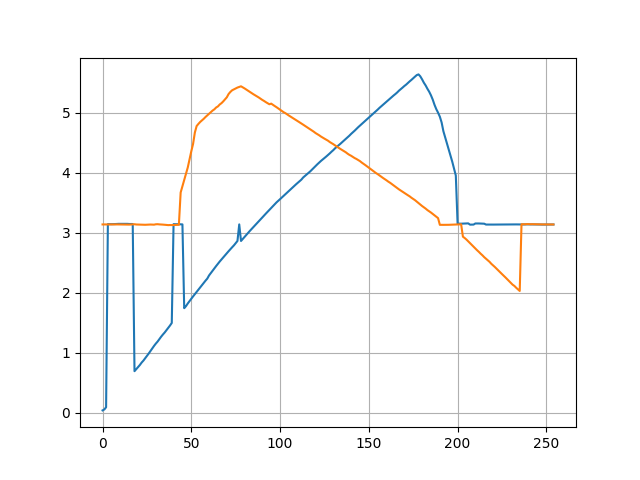

In [129]:
phases = []
pad_factor = 2
cx, cy = np.array(ref.shape)//2
cx -= -155
cy -= 0
c = 850

crop = ref[cy-c:cy+c,cx-c:cx+c]
# plt.close(0)
# plt.figure(0)
# plt.imshow(crop)
# plt.show()

ref_phase = extract_phase(ref[cy-c:cy+c,cx-c:cx+c], pad_factor, r =10, SETUP=False)
status = 0
N = 512
status_frac = 10
n = N//status_frac

for i in range(1, N):
    wrapped = extract_phase(images[i][cy-c:cy+c,cx-c:cx+c], pad_factor, r =10)

    delta = wrapped - ref_phase
    delta_mod = np.mod(delta, 2 * np.pi)

    h, w = delta_mod.shape
    roi = delta_mod[h//4:3*h//4, w//4:3*w//4]
    mean_phase = np.mean(roi)
    phases.append(mean_phase)

    if i%n == 0 :
        status += status_frac
        print(f"Processing: {status:d}%")

x1 = np.linspace(0,255,256)
x2 = np.linspace(256,511,256)
plt.close(0)
plt.figure(0)
plt.plot(phases[0:255])
plt.plot(phases[256:511])
plt.grid()
plt.show()

256
256


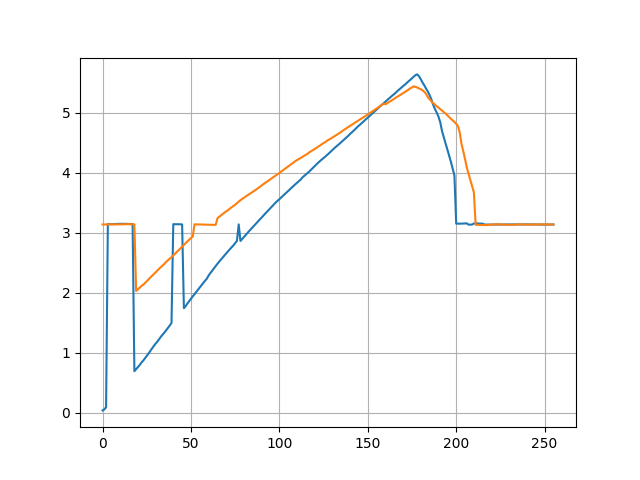

In [133]:
print(len(phases[0:256],))
x1 = np.linspace(0,255,256)


phases_up = phases[0:256]
print(len(phases_up))
phases_down = np.flip(phases[255:512])
plt.close(0)
plt.figure(0)
plt.plot(x1,phases_up)
plt.plot(x1,phases_down)
plt.grid()
plt.show()

In [77]:
print(np.max(phases)/(np.pi))

1.7942385837539547


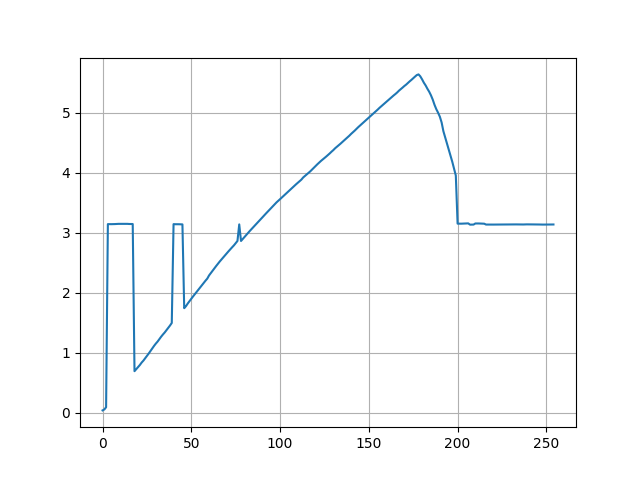

In [66]:
plt.close(0)
plt.figure(0)
plt.plot(phases)
plt.grid()
plt.show()